In [1]:
import os
import cv2
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def rgb_to_color_name(rgb):
    """
    Convierte una tupla RGB a un nombre de color en lenguaje natural.
    
    Se mapean algunos valores específicos:
      - (0, 0, 0) → "Negro"
      - (102, 102, 102) → "Gris oscuro"
      - (153, 153, 153) → "Gris"
      - (204, 204, 204) → "Gris claro"
      
    Si los tres canales son iguales pero no corresponden a ninguno de los valores anteriores,
    se devuelve un nombre indicando el nivel de gris.
    
    Para otros colores, se devuelve la representación "R, G, B".
    
    :param rgb: Tupla con los valores (R, G, B).
    :return: Nombre del color en lenguaje natural.
    """
    r, g, b = rgb
    # Comprobamos si se trata de un tono de gris (todos los canales iguales)
    if r == g == b:
        if r == 0:
            return "Negro"
        elif r == 102:
            return "Gris oscuro"
        elif r == 153:
            return "Gris"
        elif r == 204:
            return "Gris claro"
        else:
            return f"Gris ({r})"
    # Para otros colores, se puede ampliar la lógica; por ahora se devuelve la representación numérica.
    return f"{r}, {g}, {b}"


In [3]:
class ShapeClassifier:
    """
    Clase que se encarga de clasificar y dibujar la forma detectada en la imagen 
    a partir de un contorno (blob). Además, devuelve la forma y el porcentaje de 
    "región faltante" (cuña) si corresponde.
    """
    def __init__(self, image):
        """
        Inicializa el clasificador con la imagen en la que se dibujarán las marcas.
        
        :param image: Imagen en la que se van a dibujar las formas detectadas.
        """
        self.image = image

    def classify(self, cnt):
        """
        Clasifica un contorno en función de su forma y dibuja la forma detectada en la imagen.
        
        Se utiliza el área del círculo mínimo que encierra el contorno para determinar
        si se trata de un círculo. Si la diferencia de áreas es baja, se asume que es un círculo.
        En caso contrario, se intenta ajustar una elipse (si el contorno tiene al menos 5 puntos) o se
        usa una aproximación poligonal para determinar la figura (triángulo, cuadrado, hexágono, sector circular, etc.).
        
        Además, si el centroide del contorno se encuentra en la parte inferior de la imagen, se calcula el 
        porcentaje de la cuña faltante, que se define como:
        
            100 - 100 * (área del blob) / (área del círculo mínimo)
        
        :param cnt: Contorno (blob) a clasificar.
        :return: Diccionario con la clave "shape" (forma detectada) y "region_missing" (porcentaje de cuña faltante, o None).
        """
        shape = ""
        region_missing = None

        # Calculamos los momentos para obtener el centroide
        M = cv2.moments(cnt)
        if M['m00'] == 0:
            return {"shape": "Indefinido", "region_missing": None}
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        area = cv2.contourArea(cnt)

        # Calculamos el círculo mínimo que encierra el contorno
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(cx), int(cy))
        radius = int(radius)
        # Diferencia entre el área del círculo mínimo y el área del contorno
        diferencia_area_circulo = (math.pi * (radius ** 2)) - area

        # Si la diferencia es pequeña, se asume que es un círculo
        if diferencia_area_circulo < 122:
            cv2.circle(self.image, center, radius, (0, 255, 0), 2)
            shape = "Círculo"
        else:
            # Si el contorno tiene al menos 5 puntos, intentamos ajustar una elipse
            if len(cnt) >= 5:
                ellipse = cv2.fitEllipse(cnt)
                diferencia_area_elipse = ((ellipse[1][0] / 2) * (ellipse[1][1] / 2) * math.pi) - area
                if 0 < diferencia_area_elipse < 20:
                    cv2.ellipse(self.image, ellipse, (200, 130, 130), 2)
                    shape = "Elipse"
                else:
                    # Si la elipse no es adecuada, se recurre a la aproximación poligonal
                    shape, _ = self._polygon_approx(cnt)
            else:
                # Si no hay suficientes puntos, se usa directamente la aproximación poligonal
                shape, _ = self._polygon_approx(cnt)

        # Si el centroide está en la parte inferior de la imagen, calculamos el porcentaje de cuña faltante.
        if cy > 390 and radius > 0:
            region_missing = int(100 - 100 * area / (math.pi * (radius ** 2)))
        return {"shape": shape, "region_missing": region_missing}

    def _polygon_approx(self, cnt):
        """
        Aproxima el contorno a un polígono utilizando el método de Douglas-Peucker.
        
        Dependiendo del número de vértices del polígono resultante, se clasifica la figura:
          - 3 vértices: Triángulo
          - 4 vértices: Cuadrado
          - 6 vértices: Hexágono
          - Si tiene muchos lados, se asume que es un Sector Circular.
        
        :param cnt: Contorno a aproximar.
        :return: Tupla (nombre de la forma, contorno aproximado).
        """
        approx = cv2.approxPolyDP(cnt, 0.012 * cv2.arcLength(cnt, True), True)
        if len(approx) < 7:
            if len(approx) == 3:
                cv2.drawContours(self.image, [approx], 0, (255, 255, 0), 2)
                return "Triángulo", approx
            elif len(approx) == 4:
                cv2.drawContours(self.image, [approx], 0, (60, 20, 255), 2)
                return "Cuadrado", approx
            elif len(approx) == 6:
                cv2.drawContours(self.image, [approx], 0, (0, 255, 255), 2)
                return "Hexágono", approx
            else:
                cv2.drawContours(self.image, [approx], 0, (255, 0, 0), 2)
                return "Poligonal", approx
        else:
            approx = cv2.approxPolyDP(cnt, 0, True)
            cv2.drawContours(self.image, [approx], 0, (255, 0, 0), 2)
            return "Sector Circular", approx


In [4]:
class BlobAnalyzer:
    """
    Clase encargada de cargar la imagen, detectar los contornos (blobs) y analizarlos.
    
    Además, omite aquellos contornos que ocupan casi toda la imagen (por ejemplo, la imagen completa).
    """
    def __init__(self, image_path):
        """
        Inicializa el analizador verificando que la imagen exista.
        
        :param image_path: Ruta de la imagen a procesar.
        """
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"No se ha encontrado ningún fichero en la ruta: {image_path}")
        self.image_path = image_path
        self.load_image()

    def load_image(self):
        """
        Carga la imagen y crea copias para procesar y marcar los centroides.
        
        También convierte la imagen a escala de grises, aplica un umbral y
        detecta los contornos. Se calcula el área total de la imagen para descartar
        contornos que correspondan a la imagen completa.
        """
        self.image = cv2.imread(self.image_path)
        self.image_original = self.image.copy()
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        _, self.thresh = cv2.threshold(self.gray, 222, 255, cv2.THRESH_BINARY)
        self.contours, _ = cv2.findContours(self.thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        # Área total de la imagen
        self.image_area = self.image.shape[0] * self.image.shape[1]

    def analyze(self):
        """
        Recorre todos los contornos detectados y, para cada uno:
          - Descarta los contornos cuyo área sea mayor al 95% del área total (imagen completa).
          - Calcula el centroide, perímetro y área.
          - Clasifica la figura usando ShapeClassifier.
          - Dibuja el número del blob y el centroide en las imágenes.
          - Convierte el color del píxel central de BGR a RGB y lo interpreta.
        
        Devuelve una lista de diccionarios con la información de cada blob y
        dos imágenes: una con los centroides marcados y otra con las formas detectadas.
        
        :return: (lista de blobs, imagen_original_con_centroides, imagen_con_formas)
        """
        classifier = ShapeClassifier(self.image)
        blobs_info = []
        blob_label = 1

        for cnt in self.contours:
            # Calcula el área del contorno
            area = cv2.contourArea(cnt)
            # Descarta contornos que ocupen casi toda la imagen
            if area > 0.95 * self.image_area:
                continue

            M = cv2.moments(cnt)
            # Evita división por cero
            if M['m00'] == 0:
                blob_label += 1
                continue

            # Cálculo del centroide
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            # Calcula el perímetro del contorno
            perimetro = cv2.arcLength(cnt, True)

            # Se clasifica el contorno para obtener la forma y la cuña faltante
            classification = classifier.classify(cnt)
            shape = classification["shape"]
            region_missing = classification["region_missing"]

            # Dibuja el número del blob en la imagen con formas y en la original (con centroides)
            cv2.putText(self.image, str(blob_label), (cx + 3, cy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
            cv2.putText(self.image_original, str(blob_label), (cx + 3, cy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
            # Dibuja líneas en la imagen original para marcar el centroide
            cv2.line(self.image_original, (cx - 1, cy), (cx + 1, cy), (0, 255, 0), thickness=2)
            cv2.line(self.image_original, (cx, cy - 1), (cx, cy + 1), (0, 255, 0), thickness=2)

            # Se extrae el color del píxel en la posición del centroide (formato BGR) y se convierte a RGB
            b, g, r = self.image[cy, cx]
            color_rgb = (r, g, b)
            color_name = rgb_to_color_name(color_rgb)

            # Si region_missing es None o 0, se asigna "-" para indicar que la figura está completamente cerrada
            region_text = "-" if (region_missing is None or region_missing == 0) else f"{region_missing}%"

            # Se construye el diccionario con la información del blob
            blob_data = {
                "Blob": blob_label,
                "Centroide": f"({cx}, {cy})",
                "Perímetro": round(perimetro, 2),
                "Área": round(area, 2),
                "Color": color_name,
                "Clasificación": shape,
                "Región que falta": region_text
            }
            blobs_info.append(blob_data)
            blob_label += 1

        return blobs_info, self.image_original, self.image

In [5]:
class ImageDisplay:
    """
    Clase auxiliar para mostrar y guardar imágenes utilizando Matplotlib.
    """
    @staticmethod
    def mostrar_imagen(img, title, save_path):
        """
        Muestra la imagen con un título y la guarda en la ruta especificada.
        
        :param img: Imagen a mostrar (formato OpenCV).
        :param title: Título que se mostrará en la figura.
        :param save_path: Ruta del archivo donde se guardará la imagen.
        """
        plt.figure(figsize=(6, 6))
        # Se convierte la imagen de BGR a RGB para la visualización correcta
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
        plt.savefig(save_path)
        plt.show()

Tabla de blobs:


,Blob,Centroide,Perímetro,Área,Color,Clasificación,Región que falta
0,1,"(382, 393)",218.55,3417.5,Negro,Círculo,-
1,2,"(290, 394)",259.28,3299.0,Negro,Sector Circular,3%
2,3,"(197, 396)",246.79,2965.0,Negro,Sector Circular,13%
3,4,"(109, 396)",227.10,2659.5,Negro,Sector Circular,22%
4,5,"(113, 305)",179.98,1461.5,Negro,Elipse,-
5,6,"(377, 304)",218.55,3416.5,Negro,Círculo,-
6,7,"(290, 303)",211.24,3123.5,Negro,Elipse,-
7,8,"(198, 304)",198.65,2359.0,Negro,Elipse,-
8,9,"(284, 229)",205.44,2805.5,Negro,Hexágono,-
9,10,"(197, 229)",219.31,3128.0,Negro,Cuadrado,-


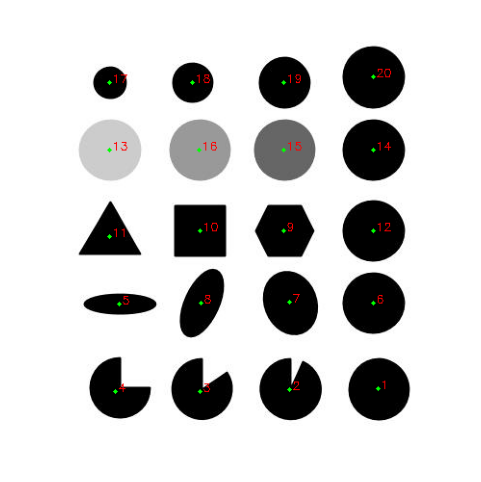

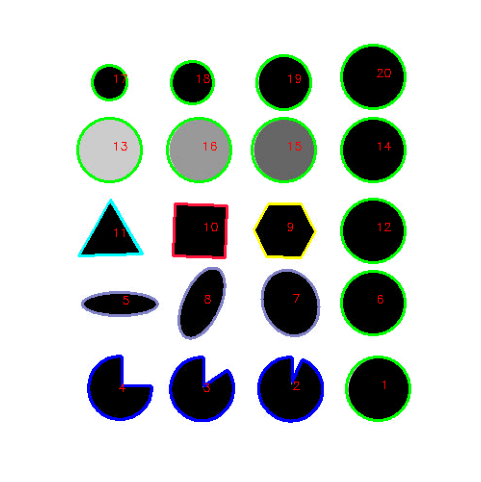

In [6]:
if __name__ == "__main__":
    # Ruta de la imagen a procesar (ajusta la ruta según tu entorno)
    ruta_imagen = '../data/blob.jpg'

    # Se crea el analizador de blobs y se procesa la imagen
    analyzer = BlobAnalyzer(ruta_imagen)
    blobs_info, imagen_con_centroides, imagen_formas = analyzer.analyze()

    # Se construye el DataFrame con la información de cada blob
    df = pd.DataFrame(blobs_info, columns=["Blob", "Centroide", "Perímetro", "Área", "Color",
                                             "Clasificación", "Región que falta"])
    print("Tabla de blobs:")
    display(df)

    # Se muestran y guardan las imágenes con los centroides y las formas detectadas.
    # Se ha cambiado el título a algo más representativo.
    titulo_imagen_original = ""
    ruta_imagen_original = "blobs/imagen_con_centroides.png"
    ImageDisplay.mostrar_imagen(imagen_con_centroides, titulo_imagen_original, ruta_imagen_original)

    titulo_formas = ""
    ruta_imagen_formas = "blobs/formas_detectadas.png"
    ImageDisplay.mostrar_imagen(imagen_formas, titulo_formas, ruta_imagen_formas)